In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import numpy as np 
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import random 
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from collections import Counter
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer

In [2]:
def set_seeds(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
set_seeds(0)

## 讀檔

In [3]:
df = pd.read_csv('sentimentData/IMDB Dataset.csv')
reviews = df['review'].values
sentiments = df['sentiment'].values

In [4]:
print('原始標籤:\n', sentiments, end = '\n\n')
print('轉換後的標籤:\n', (sentiments=='positive').astype('float32'))

原始標籤:
 ['positive' 'positive' 'positive' ... 'negative' 'negative' 'negative']

轉換後的標籤:
 [1. 1. 1. ... 0. 0. 0.]


In [5]:
tokenizer = get_tokenizer('basic_english')

print('原始文字:\n', reviews[0], end = '\n\n')
print('轉換後的文字:\n', " ".join(tokenizer(reviews[0])))

原始文字:
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to 

In [6]:
counter = Counter()
for review in reviews:
    token = tokenizer(review)
    counter.update(token)

token_vocab = vocab(counter, min_freq=10, specials=('<pad>', '<unk>'))
token_vocab.set_default_index(token_vocab.get_stoi()['<unk>'])

PAD_IDX = token_vocab.get_stoi()['<pad>']
INPUT_DIM = len(token_vocab)

reviews_ids = [torch.tensor(token_vocab.lookup_indices(tokenizer(i))) for i in reviews]
labels = (sentiments=='positive').astype('float32')

x_train, x_valid, y_train, y_valid = train_test_split(reviews_ids, labels, train_size=0.8, random_state=46, shuffle=False)

## 創建資料集

In [7]:
class IMDB(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
          
    def __getitem__(self, index):
        return self.x[index], self.y[index]
       
    def __len__(self):
        return len(self.x)
    
trainset = IMDB(x_train, y_train)
validset = IMDB(x_valid, y_valid)

In [8]:
def collate_fn(batch):    
    (x, y) = zip(*batch)
    return pad_sequence(x, padding_value=PAD_IDX, batch_first=True), torch.tensor(y)

train_loader = DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=collate_fn)
valid_loader = DataLoader(validset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=collate_fn)

In [14]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_layers=1, bidirectional=True):
        super().__init__()
        self.embedding = nn.Embedding(INPUT_DIM,  embedding_dim, padding_idx = PAD_IDX)
        self.lstm =nn.LSTM(embedding_dim, 
                           hidden_size = hidden_size, 
                           num_layers = num_layers,
                           bidirectional = bidirectional,
                           batch_first=True
        )

        hidden = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(hidden, 1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        emb_out = self.embedding(x)
        out, (h, c)  = self.lstm(emb_out)
        x = out[:, -1, :]
        x = self.fc(x)
        print(x.shape)
        return self.sigmoid(x)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(embedding_dim = 300, hidden_size= 128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [15]:
def train(epoch):
    train_loss, train_acc = 0, 0
    train_pbar = tqdm(train_loader, position=0, leave=True) # 宣告進度條
    
    model.train() # 將模型切換成訓練模式
    for input_datas in train_pbar: 
        features, labels = [i.to(device) for i in input_datas] # 將資料放入到GPU中
        optimizer.zero_grad()  # 梯度清零
        outputs = model(features).view(-1) # 模型計算答案(前向傳播)
        
        loss = criterion(outputs, labels) # 計算Loss值
        loss.backward() # 返向傳播
        optimizer.step() # 更新模型權重
        
        train_pbar.set_description(f'Train Epoch {epoch}')  # 顯示訓練次數
        train_pbar.set_postfix({'loss':f'{loss:.3f}'}) # 顯示當下模型損失
        
        pred = outputs > 0.5
        train_acc += sum(pred == labels) # 計算預測成功的數量
        train_loss += loss.item()  # 模型總損失
    return train_loss/len(train_loader), train_acc/len(trainset) # 計算一次訓練的Loss與準確率


def valid(epoch):
    valid_loss, valid_acc = 0, 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True)
    
    model.eval()
    with torch.no_grad(): 
        for input_datas in valid_pbar:
            features, labels = [i.to(device) for i in input_datas]
            outputs = model(features).view(-1)
            loss = criterion(outputs, labels)
            
            valid_pbar.set_description(f'Valid Epoch {epoch}')
            valid_pbar.set_postfix({'loss':f'{loss:.3f}'})

            pred = outputs > 0.5
            valid_acc += sum(pred == labels)
            valid_loss += loss.item()

    return valid_loss/len(valid_loader), valid_acc/len(validset)

        
def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    #標題
    plt.title('Result')
    #y軸標籤
    plt.ylabel('Loss')
    #x軸標籤
    plt.xlabel('Epoch')
    #顯示折線的名稱
    plt.legend(['train', 'valid'], loc='upper left')
    #顯示折線圖
    plt.show()

Valid Epoch 0: 100%|█████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.87it/s, loss=0.683]


Saving Model With Acc 0.50170
Train Loss: 0.69323 Train Acc: 0.49615| Valid Loss: 0.69273 Valid Acc: 0.50170| Best Acc: 0.50170



Valid Epoch 1: 100%|█████████████████████████████████████████████████████| 157/157 [00:02<00:00, 78.03it/s, loss=0.725]


Train Loss: 0.69177 Train Acc: 0.49975| Valid Loss: 0.69322 Valid Acc: 0.50170| Best Acc: 0.50170



Valid Epoch 2: 100%|█████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.15it/s, loss=0.661]


Train Loss: 0.68995 Train Acc: 0.50825| Valid Loss: 0.69371 Valid Acc: 0.50080| Best Acc: 0.50170



Valid Epoch 3: 100%|█████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.22it/s, loss=0.759]


Train Loss: 0.68769 Train Acc: 0.50635| Valid Loss: 0.69341 Valid Acc: 0.50040| Best Acc: 0.50170



Valid Epoch 4: 100%|█████████████████████████████████████████████████████| 157/157 [00:01<00:00, 84.00it/s, loss=0.718]


Train Loss: 0.68684 Train Acc: 0.50647| Valid Loss: 0.69612 Valid Acc: 0.50140| Best Acc: 0.50170



Valid Epoch 5: 100%|█████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.48it/s, loss=0.654]


Train Loss: 0.68589 Train Acc: 0.50302| Valid Loss: 0.69502 Valid Acc: 0.50040| Best Acc: 0.50170



Valid Epoch 6: 100%|█████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.79it/s, loss=0.796]


Saving Model With Acc 0.50240
Train Loss: 0.68600 Train Acc: 0.50673| Valid Loss: 0.69523 Valid Acc: 0.50240| Best Acc: 0.50240



Valid Epoch 7: 100%|█████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.58it/s, loss=0.610]


Saving Model With Acc 0.50580
Train Loss: 0.68472 Train Acc: 0.50477| Valid Loss: 0.69549 Valid Acc: 0.50580| Best Acc: 0.50580



Valid Epoch 8: 100%|█████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.68it/s, loss=0.670]


Train Loss: 0.68389 Train Acc: 0.50717| Valid Loss: 0.69239 Valid Acc: 0.50380| Best Acc: 0.50580



Valid Epoch 9: 100%|█████████████████████████████████████████████████████| 157/157 [00:01<00:00, 84.61it/s, loss=0.414]


Saving Model With Acc 0.82460
Train Loss: 0.52592 Train Acc: 0.72475| Valid Loss: 0.40941 Valid Acc: 0.82460| Best Acc: 0.82460



Valid Epoch 10: 100%|████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.87it/s, loss=0.452]


Saving Model With Acc 0.85470
Train Loss: 0.32359 Train Acc: 0.87460| Valid Loss: 0.35618 Valid Acc: 0.85470| Best Acc: 0.85470



Valid Epoch 11: 100%|████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.04it/s, loss=0.493]


Saving Model With Acc 0.87630
Train Loss: 0.23585 Train Acc: 0.91600| Valid Loss: 0.31757 Valid Acc: 0.87630| Best Acc: 0.87630



Valid Epoch 12: 100%|████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.72it/s, loss=0.211]


Saving Model With Acc 0.88040
Train Loss: 0.17951 Train Acc: 0.94305| Valid Loss: 0.33369 Valid Acc: 0.88040| Best Acc: 0.88040



Valid Epoch 13: 100%|████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.58it/s, loss=0.691]


Train Loss: 0.14679 Train Acc: 0.95677| Valid Loss: 0.33177 Valid Acc: 0.88010| Best Acc: 0.88040



Valid Epoch 14: 100%|████████████████████████████████████████████████████| 157/157 [00:01<00:00, 78.53it/s, loss=0.412]


Train Loss: 0.12537 Train Acc: 0.96455| Valid Loss: 0.35959 Valid Acc: 0.87900| Best Acc: 0.88040



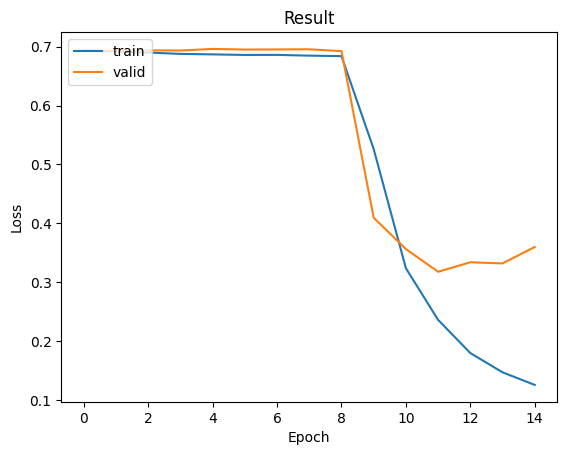

In [11]:
epochs = 15                              # 訓練次數
early_stopping = 7                      # 模型訓練幾次沒進步就停止
stop_cnt = 0                             # 計數模型是否有進步的計數器
model_path = 'model.ckpt'                # 模型存放路徑
show_loss = True                         # 是否顯示訓練折線圖
best_acc = 0                             # 最佳的準確率
loss_record = {'train':[], 'valid':[]}   # 訓練紀錄

for epoch in range(epochs):   
    train_loss, train_acc = train(epoch)
    valid_loss, valid_acc = valid(epoch)
    
    loss_record['train'].append(train_loss)
    loss_record['valid'].append(valid_loss)
    
    # 儲存最佳的模型權重
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print(f'Saving Model With Acc {best_acc:.5f}')
        stop_cnt = 0
    else:
        stop_cnt+=1
    
    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break

    print(f'Train Loss: {train_loss:.5f} Train Acc: {train_acc:.5f}', end='| ')
    print(f'Valid Loss: {valid_loss:.5f} Valid Acc: {valid_acc:.5f}', end='| ')
    print(f'Best Acc: {best_acc:.5f}', end='\n\n')

if show_loss:
    show_training_loss(loss_record)
        

In [16]:
epochs = 15                              # 訓練次數
early_stopping = 7                      # 模型訓練幾次沒進步就停止
stop_cnt = 0                             # 計數模型是否有進步的計數器
model_path = 'model.ckpt'                # 模型存放路徑
show_loss = True                         # 是否顯示訓練折線圖
best_acc = 0                             # 最佳的準確率
loss_record = {'train':[], 'valid':[]}   # 訓練紀錄

for epoch in range(epochs):   
    train_loss, train_acc = train(epoch)
    valid_loss, valid_acc = valid(epoch)
    
    loss_record['train'].append(train_loss)
    loss_record['valid'].append(valid_loss)
    
    # 儲存最佳的模型權重
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print(f'Saving Model With Acc {best_acc:.5f}')
        stop_cnt = 0
    else:
        stop_cnt+=1
    
    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break

    print(f'Train Loss: {train_loss:.5f} Train Acc: {train_acc:.5f}', end='| ')
    print(f'Valid Loss: {valid_loss:.5f} Valid Acc: {valid_acc:.5f}', end='| ')
    print(f'Best Acc: {best_acc:.5f}', end='\n\n')

if show_loss:
    show_training_loss(loss_record)
        

  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

torch.Size([64, 1])


Train Epoch 0:   1%|▍                                                      | 5/625 [00:00<00:38, 16.10it/s, loss=0.682]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


Train Epoch 0:   2%|█▏                                                    | 14/625 [00:00<00:21, 29.09it/s, loss=0.712]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


Train Epoch 0:   4%|█▉                                                    | 22/625 [00:00<00:18, 32.79it/s, loss=0.696]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


Train Epoch 0:   4%|██▎                                                   | 27/625 [00:01<00:16, 35.60it/s, loss=0.692]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


Train Epoch 0:   6%|███                                                   | 36/625 [00:01<00:15, 37.14it/s, loss=0.694]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


Train Epoch 0:   7%|███▉                                                  | 45/625 [00:01<00:15, 37.90it/s, loss=0.696]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


Train Epoch 0:   8%|████▌                                                 | 53/625 [00:01<00:14, 38.15it/s, loss=0.699]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


Train Epoch 0:   9%|████▉                                                 | 57/625 [00:01<00:15, 35.83it/s, loss=0.704]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


Train Epoch 0:  10%|█████▌                                                | 65/625 [00:02<00:15, 35.07it/s, loss=0.701]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


Train Epoch 0:  12%|██████▍                                               | 74/625 [00:02<00:14, 36.95it/s, loss=0.699]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


Train Epoch 0:  12%|██████▋                                               | 78/625 [00:02<00:16, 33.39it/s, loss=0.694]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


KeyboardInterrupt: 

In [17]:
model = LSTM(embedding_dim = 300, hidden_size= 128).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

LSTM(
  (embedding): Embedding(29065, 300, padding_idx=0)
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [23]:
text = x_valid[0].unsqueeze(0).to(device)
model(text)

torch.Size([1, 1])


tensor([[0.0224]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [26]:
label_decoding = {0:'negative', 1:'positive'}
text = x_valid[0].unsqueeze(0).to(device)

output = model(text)                                     
pred = (output.view(-1) > 0.5)
label = y_valid.tolist()[0]                                # 取得Label

print('Pred Label:',label_decoding[int(pred)])             # 顯示文字 
print('Real Label:',label_decoding[label])                 # 顯示文字 
print('Reivew:\n', " ".join(token_vocab.lookup_tokens(x_valid[0].tolist())))


torch.Size([1, 1])
Pred Label: negative
Real Label: negative
Reivew:
 first off i want to say that i lean liberal on the political scale and i found the movie offensive . i managed to watch the whole <unk> disgrace of a film . this movie brings a low to original ideas . yes it was original thus my 2 stars instead of 1 . are our film writers that uncreative that they can only come up with this ? ? acting was horrible , and the characters were unlikeable for the most part . the lead lady in the story had no good qualities at all . they made her <unk> into some sort of a bad guy and i did not see that at all . maybe i missed something , i do not know . he was the most down to earth , relevant character in the movie . i did not shell out any money for this garbage . i almost wish peta would come to the rescue of this awful , offensive movie and form a protest . disgusting thats all i have to say anymore !
